# Example of Explanation

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import pickle
import pylab
import numpy as np
import scipy
import torch.optim as optim
import pandas as pd
import torchvision.datasets as datasets

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import shapiro, normaltest

from torchvision import transforms

from copy import deepcopy

# Local imports
from local_models import *
from helper_functions import *
from piece_hurdle_model import *
from optimize_explanations import *
from evaluation_metrics import *

from IPython.display import Image

# torch.autograd.set_detect_anomaly(True)
%load_ext autoreload
%autoreload 2


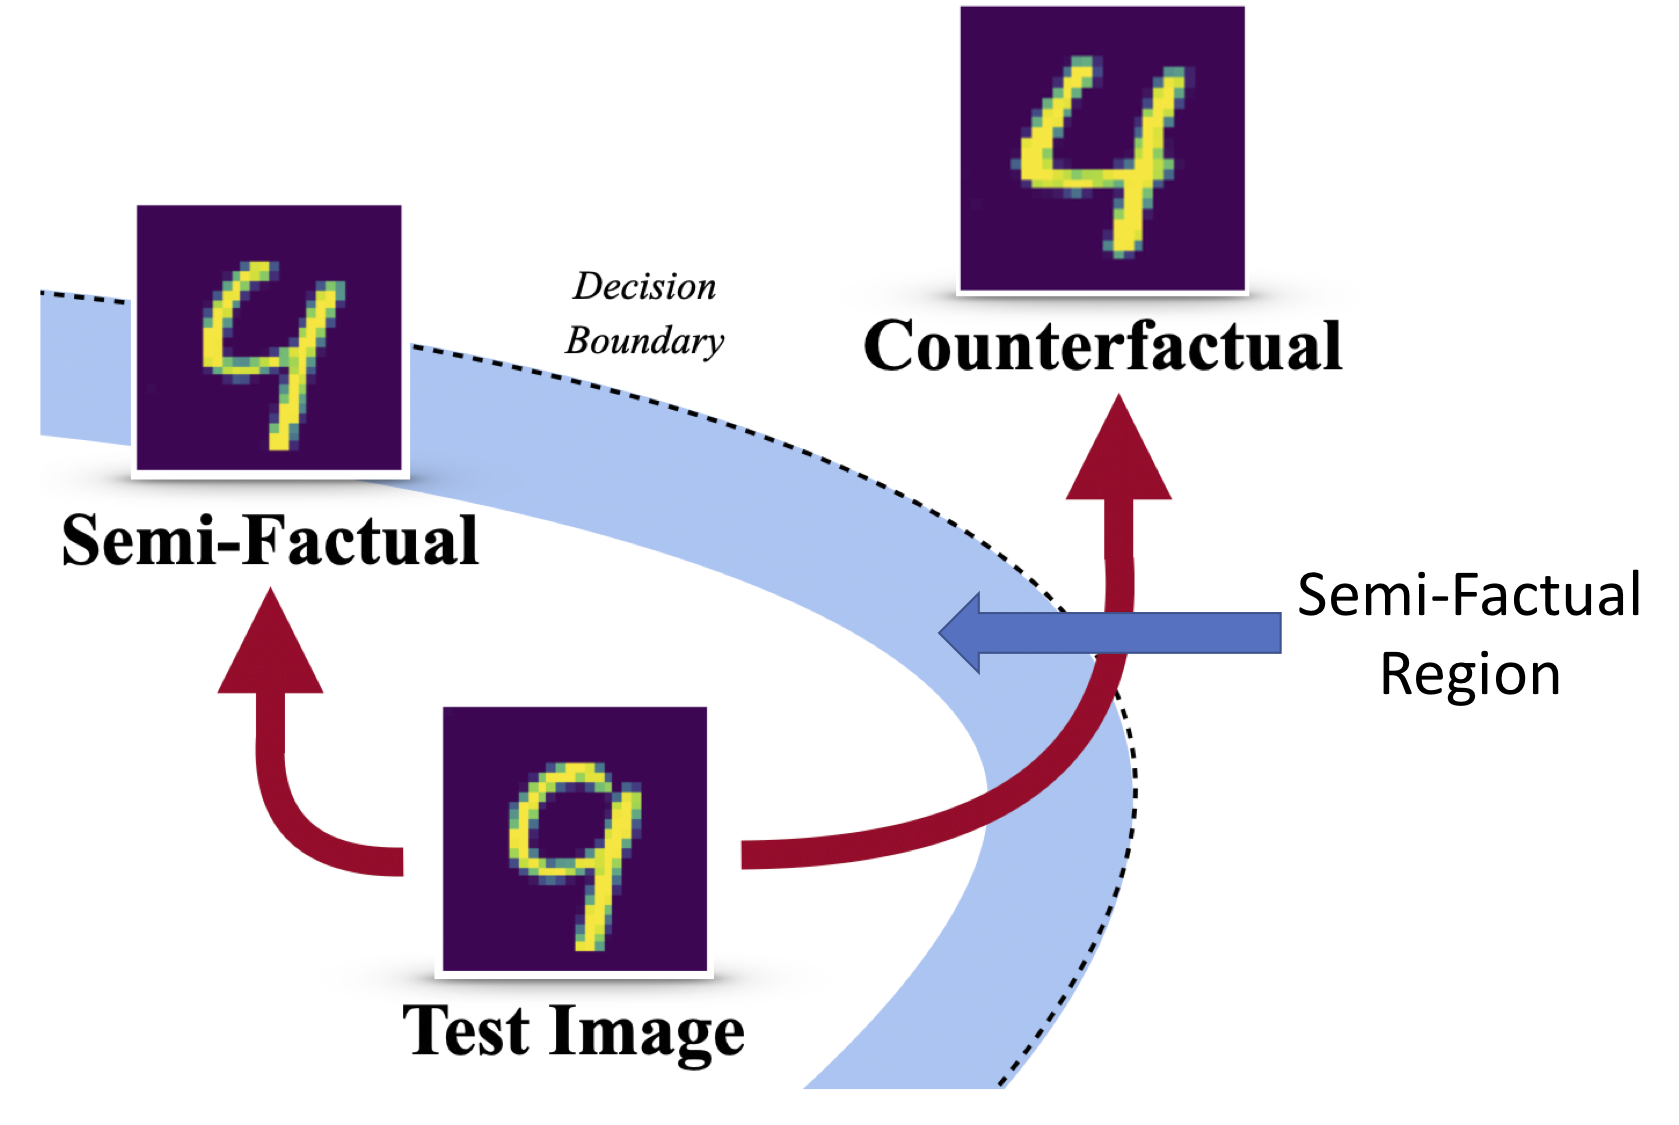

In [2]:
Image("imgs/overview.png", width=500)

In [ ]:
# Load models and data for MNIST
G, cnn = load_models(CNN, Generator)
train_loader, test_loader = load_dataloaders()
X_train, y_train, X_test, y_test = get_MNIST_data(datasets)

Extracting ./data/after_anon_review.../MNIST/raw/train-images-idx3-ubyte.gz to ./data/after_anon_review.../MNIST/raw



Extracting ./data/after_anon_review.../MNIST/raw/train-labels-idx1-ubyte.gz to ./data/after_anon_review.../MNIST/raw


Extracting ./data/after_anon_review.../MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/after_anon_review.../MNIST/raw


Extracting ./data/after_anon_review.../MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/after_anon_review.../MNIST/raw
Processing...
Done!




The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)


## Load Distribution Data

PIECE models the distribution on latent features using ReLU activations. Look at the cnn here.

In [4]:
cnn

CNN(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout2d(p=0.1, inplace=False)
    (12): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Dropout2d(p=0.2, inplace=False)
    (16): Conv2d(64, 128, kernel_size=(

## Note
Layers 16-18 and the (classifier) attribute are the important parts.

Layers 16-18: After these layers a 3D convolutional block is outputted in the shape of (batch_size, num_channels, height, width). Global average pooling is then utilized to acquire a set of latent features x. See below

In [5]:
batch = next(iter(test_loader))
imgs, labels = batch

In [6]:
logits, x = cnn(imgs)

In [7]:
x.shape

torch.Size([1, 128])

Here the batch size is one, so $x$ has just one example. These $x$ values are collected for all training data. 

Next, I used all training data to make a dictionary, which has all classes as its keys (1-10 here in MNIST), and all $x$ data for that class were the cnn predicted it to belong to that class.

Note this means that if (for example) an 8 is misclassified as a 3, it will belong to the key 3 in the dictionary. We are modelling what the CNN thinks is true, not what the labels are.

## Collect Latent $x$ for all training data 

In [8]:
def return_feature_contribution_data(data_loader, cnn, num_classes=10):
    
    full_data = dict()
    pred_idx = dict() 

    for class_name in list(range(num_classes)):
        pred_idx[class_name] = list()
        
    for i, data in enumerate(data_loader):
        # print progress
        if i % 10000 == 0:
            print(  100 * round(i / len(data_loader), 2), "% complete..."  )     
        image, label = data
        label = int(label.detach().numpy())
        acts = cnn(image)[1][0].detach().numpy()
        pred = int(torch.argmax(  cnn(image)[0]  ).detach().numpy()) 
        pred_idx[pred].append(acts.tolist())
                
    return pred_idx

In [9]:
pred_idx_train = return_feature_contribution_data(train_loader, cnn)

0.0 % complete...
17.0 % complete...
33.0 % complete...
50.0 % complete...
67.0 % complete...
83.0 % complete...


In [10]:
pred_idx_train.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
len(pred_idx_train[0])

5925

In [12]:
# Probabilitiy threshold for identifying "Exceptional Features" with PIECE
alpha = 0.001

Label: 8
Prediction: 3


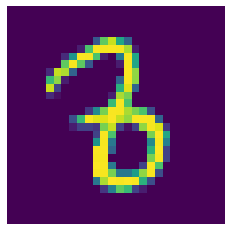

In [13]:
rand_num = 14  # pick incorrectly classified instance as an example

# Get Query representations
original_query_idx, original_query_img, target_class = get_missclassificaiton(test_loader, cnn, rand_num)
original_query_pred = int(torch.argmax(cnn(original_query_img)[0]))

## Locate This in GAN
There are many methods to locate an image in the gan's latent space such that $G(z) \approx I$. Here we just took a loss in the pixel space and the latent space combined to find them, see our paper for details

In [14]:
z = torch.load("data/latent_g_input_saved/incorrect_latent/misclassify_" + str(rand_num) + ".pt") 
query_x = cnn(G(z))[1][0]

In [15]:
np.array(pred_idx_train[0]).shape

(5925, 128)

In [16]:
#### ========== First step of PIECE Algorithm ========== ####
# Step 1: Acquire the probability of each features, 
# and identify the excpetional ones (i.e., those with a probability lower than alpha)
df = acquire_feature_probabilities(pred_idx_train, target_class, cnn,
                                   original_query_img=original_query_img,
                                   alpha=alpha) 

In [17]:
# Step 2: Filter out exceptional features which we want to change, and change them to their expected values in the counterfactual class
df = filter_df_of_exceptional_noise(df, target_class, cnn, alpha=alpha)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
# Sort by least probable to the most probable
df = df.sort_values('Probability of Event')

In [19]:
print("% Features Changed to Expected Value:", 100 * df.shape[0] / 128)

% Features Changed to Expected Value: 21.875


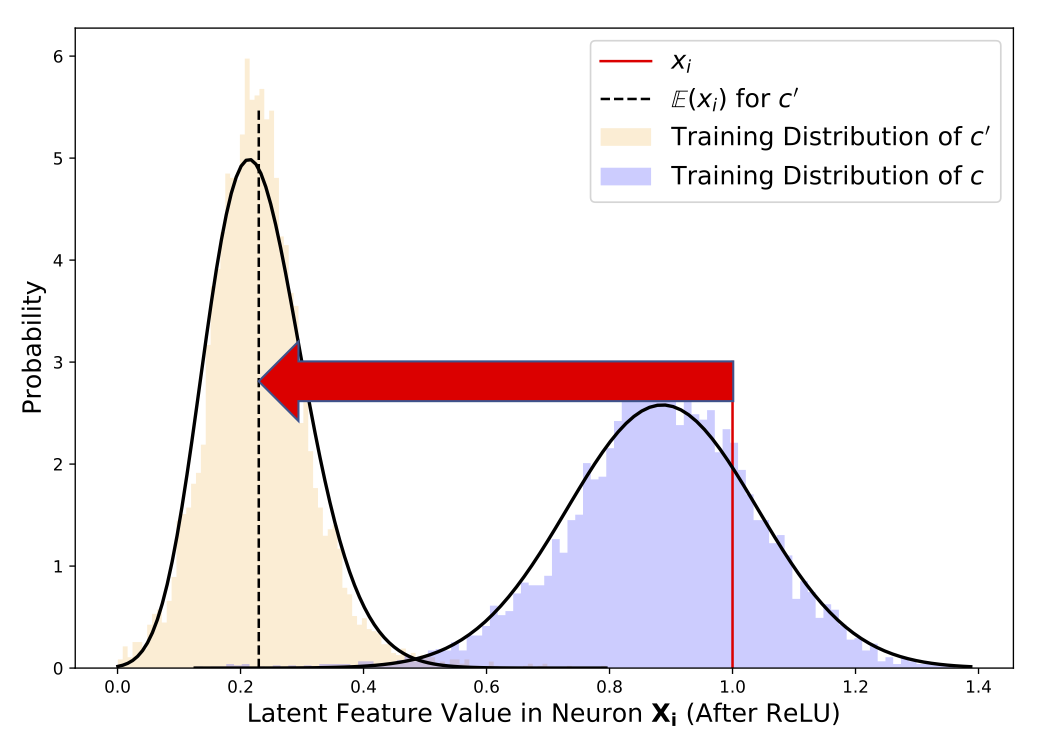

In [20]:
Image("imgs/expected_value.png", width=500)

In [21]:
# Get x' -- The Ideal Explanation
ideal_xp = modifying_exceptional_features(df, target_class, query_x)   
ideal_xp = ideal_xp.clone().detach().float().requires_grad_(False)

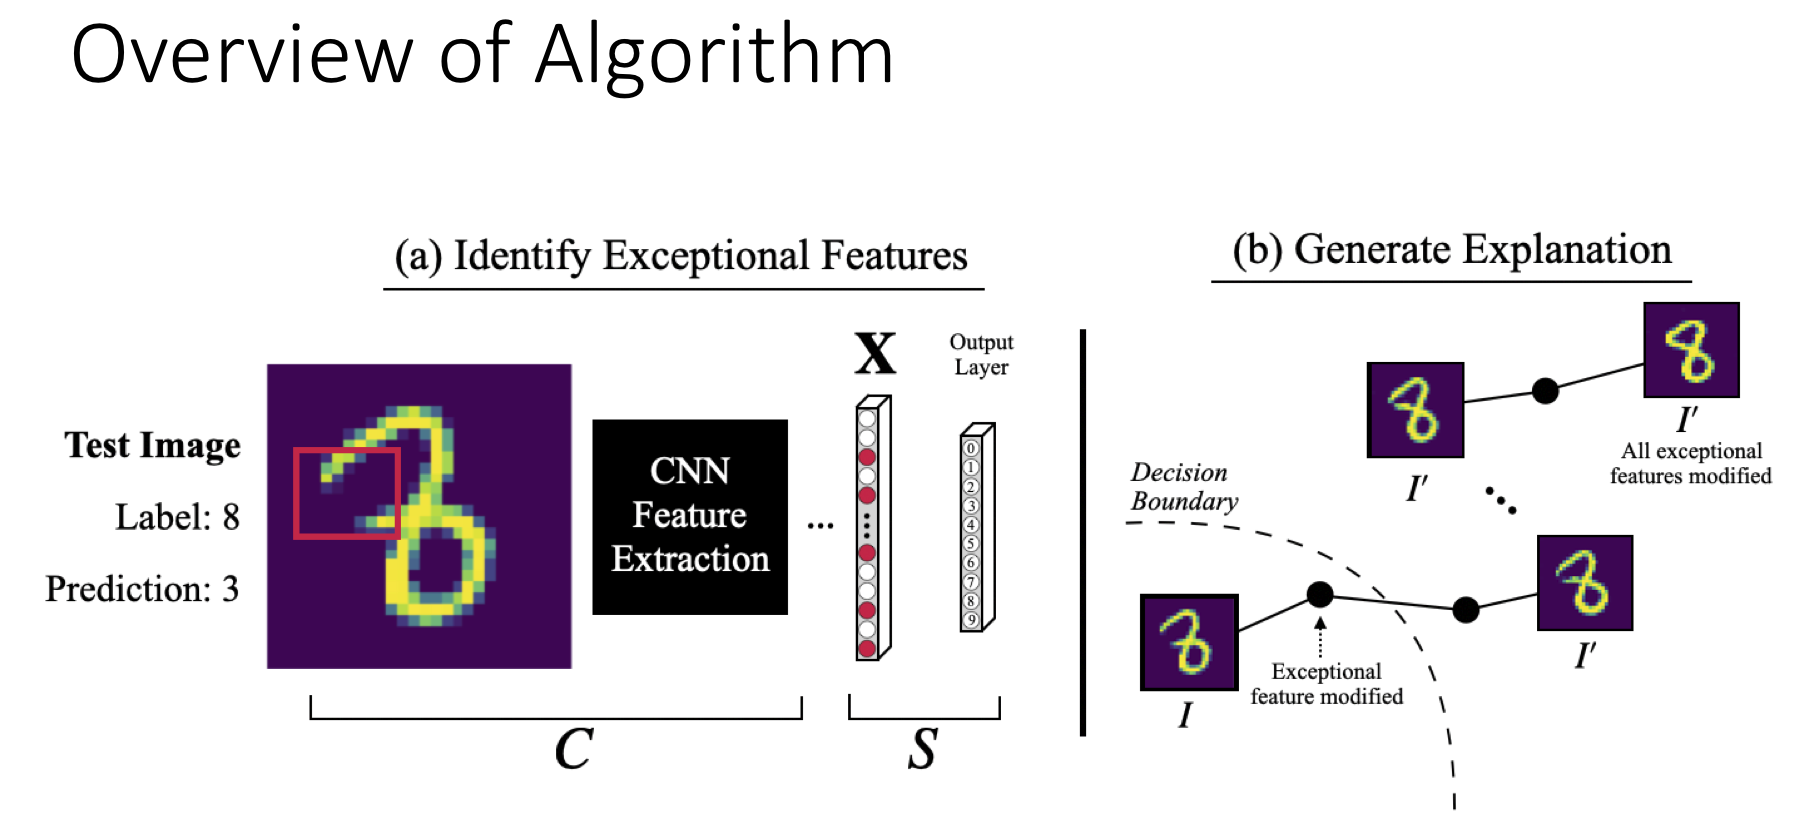

In [22]:
Image("imgs/algorithm.png", width=800)

In [23]:
# Query
x_q = cnn(G(z))[1][0]

# Explanation latent input (to optimize...)
z_e = z.clone().detach().float().requires_grad_(True)
criterion = nn.MSELoss()
optimizer = optim.Adam([z_e], lr=0.001)

In [24]:
for i in range(500):

    optimizer.zero_grad()
    logits, x_e = cnn(G(z_e))
    loss = criterion(x_e[0], ideal_xp)

    loss.backward()  
    optimizer.step()  

    if i % 50 == 0:
        print("Loss:", loss.item())


Loss: 0.0881194919347763
Loss: 0.06365746259689331
Loss: 0.05170486122369766
Loss: 0.04985884204506874
Loss: 0.048215050250291824
Loss: 0.04683704674243927
Loss: 0.04561128094792366
Loss: 0.04100723937153816
Loss: 0.02547679841518402
Loss: 0.024295389652252197


## Counterfactual Explanation
If the query looked like this, I would have thought it was an 8 instead of a 3.

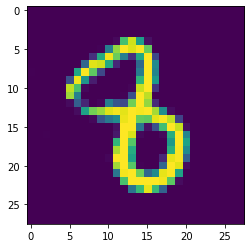

In [25]:
plt.imshow( G(z_e).detach().numpy()[0][0])

# Semi-Factual Example

In [26]:
def get_6_digits(test_loader, digit, cnn):
    count = 0
    idxs = list()
    for i, data in enumerate(test_loader):
        img, label = data
        
        if float(cnn(img)[0][0][label]) > 0.999 and label == digit:
            idxs.append(i)
            count += 1
        if count == 6:
            return idxs

In [27]:
def get_classification(test_loader, cnn, lucky_idx):
	for i, data in enumerate(test_loader):
		image, label = data
		if i == lucky_idx:
			break
				
	original_query_idx = i
	original_query_img = image
	original_query_label = label.detach().numpy()[0]

	numpy_img = image.reshape(28,28).detach().numpy()
	plt.imshow(convert_normalization(numpy_img))
	plt.axis('off')
	# plt.savefig('Evidence/Query.pdf')
	print("Label:", int(label))
	print("Prediction:", torch.argmax(cnn(image)[0][0]).detach().numpy())
	return original_query_idx, original_query_img, original_query_label

In [28]:
def semi_factual_optim(df, target_class, query_activations):
	"""
	A greedy optimization towards the nearest counterfactual instance
	"""

	ideal_xp = query_activations.clone().detach()
	changed = 0
	distances = list()
	results = list()
	
	for idx, row in df.sort_values('Probability of Event', ascending=True).iterrows():
		feature_idx = int(row['Feature Map'])  
		expected_value = row['Expected Value'] 
		ideal_xp[feature_idx] = expected_value
		changed += 1
		pred = int(torch.argmax(  cnn.classifier(ideal_xp.reshape(1,-1))  ))

		if pred == target_class:
			ideal_xp[feature_idx] = query_activations[feature_idx]
			break

	return ideal_xp, changed

In [29]:
def find_cf_gradient_ascent(z, lr, G, original_query_label, cnn):

	z_temp = z.clone().detach().requires_grad_(True)
	optimizer = optim.Adam([z_temp], lr=lr)
	criterion = torch.nn.MSELoss()
	output_t = torch.tensor([0,0,0,0,0,0,0,0,0,0], dtype=torch.float32)
	output_t[original_query_label] = 1
	epoch = 0

	while True:
		epoch += 1
		optimizer.zero_grad()

		output_e_raw = cnn(G(z_temp))[0] 
		output_e = torch.nn.functional.softmax(output_e_raw, dim=1)[0]
		loss = criterion(output_e, output_t)
		(-loss).backward(retain_graph=True)  
		optimizer.step()

		pred = int(torch.argmax(output_e))
		if pred != original_query_label:
			return pred

		if epoch == 10000:
			return None

In [30]:
## Find 40 examples for experiment
proto_idxs = list()
for digit in [0,1,2,3,4,5,6,7,8,9]:
    proto_idxs.append(get_6_digits(test_loader, digit, cnn))
proto_idxs = np.array(proto_idxs).flatten()

Label: 8
Prediction: 8


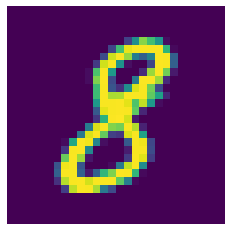

In [31]:
cnn = cnn.eval()

xxx = 50

query_idx = proto_idxs[xxx]
original_query_idx, original_query_img, original_query_label = get_classification(test_loader, cnn, query_idx)

In [32]:
z = torch.load("data/latent_g_input_saved/correct_latent/proto_classify_" + str(query_idx) + ".pt") 

In [33]:
query_activations = cnn(G(z))[1][0]

In [34]:
target_class = find_cf_gradient_ascent(z, 0.1, G, original_query_label, cnn)
print("Counterfactual Class is:", target_class)

Counterfactual Class is: 3


In [35]:
#### ========== First step of PIECE Algorithm ========== ####
# Step 1: Acquire the probability of each features, 
# and identify the excpetional ones (i.e., those with a probability lower than alpha)
df = acquire_feature_probabilities(pred_idx_train, target_class, cnn,
                                   original_query_img=original_query_img,
                                   alpha=alpha) 

In [36]:
# Step 2: Filter out exceptional features which we want to change, and change them to their expected values in the counterfactual class
df = filter_df_of_exceptional_noise(df, target_class, cnn, alpha=alpha)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
# Sort by least probable to the most probable
df = df.sort_values('Probability of Event')

In [38]:
ideal_xp, changed = semi_factual_optim(df, target_class, query_activations)

In [39]:
changed

24

In [40]:
# Query
x_q = cnn(G(z))[1][0]

# Explanation latent input (to optimize...)
z_e = z.clone().detach().float().requires_grad_(True)
criterion = nn.MSELoss()
optimizer = optim.Adam([z_e], lr=0.01)

In [41]:
for i in range(300):

    optimizer.zero_grad()
    logits, x_e = cnn(G(z_e))
    loss = criterion(x_e[0], ideal_xp)

    loss.backward(retain_graph=True)  
    optimizer.step()  

    if i % 50 == 0:
        print("Loss:", loss.item())


Loss: 0.11839348077774048
Loss: 0.08831855654716492
Loss: 0.05758220702409744
Loss: 0.054510653018951416
Loss: 0.05198707431554794
Loss: 0.051203418523073196


## Semi-Factual Explanation/Justification
Even if the query looked like this (i.e., closer to a 3, the counterfactual class), I still would have thought it was an 8. Ergo, the initial classification is definitely correct.

Prediction: tensor(8)


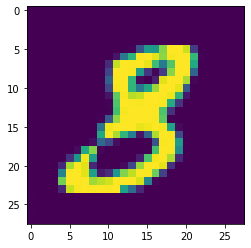

In [42]:
print("Prediction:", torch.argmax(cnn(G(z_e))[0])  )
plt.imshow( G(z_e).detach().numpy()[0][0])